In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np  # Thinly-wrapped version of Numpy
from autograd import grad, elementwise_grad
from autograd import extend

EPS_TOL = 1e-10

In [2]:
def grad_descent(f, df_dx, initial_x):
    alpha = 1.0
    curr_x = initial_x
    #   print("start val: {}".format(f(curr_x)))
    for i in range(10):
        curr_val = f(curr_x)
        for j in range(25):
            grad_x = df_dx(curr_x)
            new_x = curr_x - alpha * grad_x
            new_val = f(new_x)
            if new_val < curr_val:
                curr_x = new_x
                break
            else:
                alpha /= 2.
    curr_grad = df_dx(curr_x)
    #   print("end val: {} | grad_value: {}".format(f(curr_x), curr_grad))
    converged = curr_grad < EPS_TOL
    if not converged:
        print("DID NOT CONVERGE! CHECK")
    return curr_x


In [16]:
def O2(x, y):
    return (3 * x + y) ** 2

def O3(x, y):
    return (15*x - 2*y)**2

initial_y = 4.0

@extend.primitive
def argmin_O(x, O=O2):
    f = lambda y: O(x, y)
    return grad_descent(f, grad(f), initial_y)


def O1(x):
    y = argmin_O(x, O=O3)  # THIS HAS TO CONVERGE!
    return (y - 5) ** 2

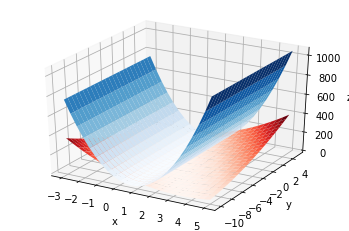

In [17]:
x = np.linspace(-3, 5, 25)
y = np.linspace(-10, 5, 25)

X, Y = np.meshgrid(x, y)
Z1 = O2(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='Reds')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Z2 = np.empty(X.shape)
for i in range(len(X)):
    for j in range(len(Y)):
        Z2[i, j] = O1(X[i, j])
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1,
                cmap='Blues', edgecolor='none')
plt.show()

In [18]:
"""
OPTIMIZE VIA CLASSIC SENSITIVITY
"""

def optimize(initial_x):
    f = lambda x: O1(x)
    dO2_dy = g = lambda x, y: 2 * (3 * x + y)

    pO1_px = 0
    pO1_py = lambda x, y: 2 * (y + 5)

    pg_py = 2
    pg_px = 6

    def dO1_dx(x):
        y = argmin_O(x)
        return pO1_px + pO1_py(x, y) * (1. / pg_py * pg_px)

    new_x = grad_descent(f, dO1_dx, initial_x)
    return new_x

initial_x = 2.0
initial_y = 4.0

x_optimal = optimize(initial_x)
y_optimal = argmin_O(x_optimal)

print("x_optimal: {}, y_optmial: {} | val: {}".format(x_optimal, y_optimal, O1(x_optimal)))


x_optimal: 2.0, y_optmial: -6.0 | val: 100.0


In [19]:
"""
LETS TRY WITH AUTODIFF ?
"""

def argmin_O_vjp(ans, x, O=O2):
    """
    This should return the jacobian-vector product 
    it should calculate d_ans/dx because the vector contains dloss/dans
    then we get with dloss/dans * dans/dx = dloss/dx which we're actually interested in
    """
    g = elementwise_grad(O, 1)
    dg_dy = elementwise_grad(g, 1)(x, initial_y)
    dg_dx = elementwise_grad(g, 0)(x, initial_y)
    if np.ndim(dg_dy) == 0: # we have just simple scalar function so we just have to divide instead of inverse
        return lambda v: v*(1./dg_dy)*dg_dx
        
    return lambda v: v * np.matmul(np.linalg.inv(dg_dy), dg_dx)


def optimize_autodiff(initial_x):
    f = lambda x: O1(x)

    new_x = grad_descent(f, grad(f), initial_x)
    return new_x

extend.defvjp(argmin_O, argmin_O_vjp)

x_optimal = optimize_autodiff(initial_x)
y_optimal = argmin_O(x_optimal)

print("x_optimal: {}, y_optmial: {} | val: {}".format(x_optimal, y_optimal, O1(x_optimal)))



x_optimal: 2.0, y_optmial: -6.0 | val: 100.0


In [20]:

@extend.primitive
def add_const(x, c=5.0):
    return x + c

def add_const_vjp(ans, x, c=5.0):
    return lambda g: g*1


def loss(y):
    return (y - 7)**2

def f(x):
    k = add_const(x, 8)
    return loss(k)

extend.defvjp(add_const, add_const_vjp)


x_opt = grad_descent(f, grad(f), 7.)

print("should be 0 and its: {} with x_opt: {}".format(f(x_opt), x_opt))


should be 0 and its: 0.0 with x_opt: -1.0
